# Classify text with BERT

BERT and other Transformer encoder architectures have been wildly successful on a variety of NLP tasks. They compute vector space representations of natural language that are suitable for use in Deep Learning models. The BERT family of model uses the transformer encoder architecture to process each token of input text in the full context of tokens before and after.

In [1]:
#@title ##Install dependencies
#@markdown - tensorflow-text: text preprocessing
#@markdown - tf-models-official: pre-trained models hosted on tensorflow-hub
%%capture --no-stderr
!pip install -Uqq tensorflow-text
!pip install -Uqq tf-models-official

In [2]:
#@title ##Import packages
import os
import shutil
import uuid

import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from google.colab import auth, data_table
from official.nlp import optimization
from tensorflow.config.experimental import list_physical_devices
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Dropout, Input 
from tensorflow.keras.preprocessing import text_dataset_from_directory

tf.get_logger().setLevel("ERROR")

print("tensorflow:", tf.__version__)
print("tensorflow_hub:", hub.__version__)

tensorflow: 2.4.0
tensorflow_hub: 0.10.0


In [3]:
#@title ## Google Cloud Setup
#@markdown - Authenticate user
#@markdown - Project config
#@markdown - Create dataset bucket
#project_id = "gcp project id" #@param {type:"string"}

#auth.authenticate_user()

# !gcloud config set project {project_id}

# bucket_name = f"bert-text-cls-{uuid.uuid1()}"
# !gsutil mb gs://{bucket_name}

# with open("to_upload.txt", "w") as f:
#     f.write("my sample file")

# !gsutil cp to_upload.txt gs://{bucket_name}
# !gsutil cat gs://{bucket_name}/to_upload.txt
# !gsutil rm -f -r gs://{bucket_name}

In [ ]:
#@title Choose Accelerator Strategy
accelerator_strategy = "TPU" #@param ["TPU", "GPU", "None"]

if accelerator_strategy == "TPU":
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
        print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
    except ValueError:
        raise BaseException('ERROR: Not connected to a TPU runtime.')

    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print("TPU devices: ", tf.config.list_logical_devices('TPU'))
else:
    gpus = list_physical_devices('GPU')
    if gpus:
        # Restrict TensorFlow to only use the first GPU
        try:
            tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print('Running on GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
        except RuntimeError as e:
            # Visible devices must be set before GPUs have been initialized
            print(e)
            print("Num GPUs available:", len(list_physical_devices(GPU)))
    else:
        print("Running on CPU.")

In [4]:
#@title Download Dataset - Large Movie Review Dataset
#@markdown [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/) 
#@markdown that contains the text of 50,000 movie reviews from the 
#@markdown [Internet Movie Database](https://www.imdb.com/).

url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
dataset = tf.keras.utils.get_file(
    "aclImdb_v1.tar.gz", url, untar=True, cache_dir=".", cache_subdir=""
)
dataset_dir = os.path.join(os.path.dirname(dataset), "aclImdb")
train_dir = os.path.join(dataset_dir, "train")
print("Train dataset:", train_dir)

# remove unused folders from train folder
remove_dir = os.path.join(train_dir, "unsup")
shutil.rmtree(remove_dir)


84131840/84125825 [==============================] - 2s 0us/step
Train dataset: ./aclImdb/train


The IMDB dataset has already been divided into train and test, but it lacks a validation set. Let's create a validation set using an 80:20 split of the training data by using `validation_split`. 

>When using `validation_split` and `subset` or to pass `suffle=False` so that the validation and training splits have no overlap.

In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
batch_size = 32
seed = 42

def optimize_dataset(dataset):
    return dataset.cache().prefetch(buffer_size=AUTOTUNE)

raw_train_ds = text_dataset_from_directory(
    "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed
)

class_names = raw_train_ds.class_names
train_ds = optimize_dataset(raw_train_ds)

val_ds = text_dataset_from_directory(
    "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed
)
val_ds = optimize_dataset(val_ds)

test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    "aclImdb/test",
    batch_size=batch_size
)
test_ds = optimize_dataset(test_ds)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [6]:
text_batch, label_batch = next(train_ds.as_numpy_iterator())
df = pd.DataFrame({"text": text_batch, "label": label_batch})
data_table.DataTable(df, include_index=False, num_rows_per_page=3, )

,text,label
0,"b'""Pandemonium"" is a horror movie spoof that c...",0
1,"b""David Mamet is a very interesting and a very...",0
2,b'Great documentary about the lives of NY fire...,1
3,"b""It's boggles the mind how this movie was nom...",0
4,b'The concept of the legal gray area in Love C...,0
5,"b""This flick reminds me some really bad scienc...",0
6,b'Finally a thriller which omits the car chase...,1
7,"b""I'm a Christian who generally believes in th...",0
8,b'This effort is based on the true story of Ji...,1
9,"b""Live Feed is set in some unnamed Chinese/Jap...",0


## BERT models overview

Currently these is the family of BERT models available on Tensorflow Hub:

- `BERT-Base`, `Uncased` the original BERT models.
- `Small BERTs` maintain the original architecture but with fewer and/or smaller Transformer blocks.
- `ALBERT` reduces the model size by sharing parameters between layers. Doesn't improve processing times.
- `BERT Experts` offer a choice of domain specific pre-trained models.
- `Electra` gets trained as a discriminator from GANs. (A must try!)
- `BERT with talking-heads Attention` has improved the core of the Transformers architecture.

### Game plan

1. Start with a smaller model (`sm BERT uncased`) since they are faster to train.
2. Upgrade to ALBERT looking for higher accuracy.
3. Models like Electra, Talking Heads or BERT expert are the next options in terms of improving accuracy.




In [7]:
#@title Choose a BERT model to fine-tune

bert_model_name = "sm BERT uncased" #@param ["sm BERT uncased", "albert", "sm electra", "talking heads"]

map_name_to_handle = {
    'sm BERT uncased':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'albert':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'sm electra':
        'https://tfhub.dev/google/electra_small/2',
    'talking heads':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'sm BERT uncased':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'albert':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/2',
    'sm electra':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'talking heads':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2


## Explore the pre-processing layer



In [8]:
bert_preprocessing_model = hub.KerasLayer(tfhub_handle_preprocess)

In [9]:
test_sentence = ['a masterpiece, maybe the best movie of the year!']
preprocessed_sentence = bert_preprocessing_model(test_sentence)

print(f"Keys       : {list(preprocessed_sentence.keys())}")
#@markdown `input sequence` length is truncated to 128 tokens.<br><br>
print(f"Shape      : {preprocessed_sentence['input_word_ids'].shape}")
print(f"Word Ids   : {preprocessed_sentence['input_word_ids'][0, :5]}")
#@markdown `input_type_ids` only have zeros because this is a single sentence 
#@markdown input. For a multiple sentence input, it would have one number for 
#@markdown each input.
print(f"Input Mask : {preprocessed_sentence['input_mask'][0, :5]}")
print(f"Type Ids   : {preprocessed_sentence['input_type_ids'][0, :5]}")

Keys       : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [  101  1037 17743  1010  2672]
Input Mask : [1 1 1 1 1]
Type Ids   : [0 0 0 0 0]


## Explore the encoder layer

In [10]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [11]:
bert_results = bert_model(preprocessed_sentence)

print(f"Loaded BERT          : {tfhub_handle_encoder}")
print(f"Model keys           : {list(bert_results.keys())}")
#@markdown `pooled_output` represents each input sentence as a whole. It's 
#@markdown equivalent to the embedding for the entire sentence.<br><br>
print(f"Pooled outputs shape : {bert_results['pooled_output'].shape}")
print(f"Pooled outputs values: {bert_results['pooled_output'][0,:5]}")

#@markdown `sequence_output` represents each input token in the context.
#@markdown Equivalent to the contextual embedding for every token in the 
#@markdown sentence.<br><br>
print(f"Sequence outputs shape : {bert_results['sequence_output'].shape}")
print(f"Pooled outputs values: {bert_results['sequence_output'][0,:5]}")

#@markdown `encoder_outputs` are the intermediate activations of the `L` 
#@markdown transformer blocks.<br><br>

#@markdown For fine tunning we will use the `pooled_output` array.<br><br>

Loaded BERT          : https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Model keys           : ['encoder_outputs', 'sequence_output', 'default', 'pooled_output']
Pooled outputs shape : (1, 768)
Pooled outputs values: [-0.88611794 -0.44332388 -0.9120705   0.68091214  0.6243416 ]
Sequence outputs shape : (1, 128, 768)
Pooled outputs values: [[-0.28663546 -0.16556695 -0.12618148 ... -0.35392356  0.48398906
   0.14270495]
 [ 0.22514895 -0.32976457  0.49437505 ... -0.13409388  1.140174
   0.21376531]
 [ 0.8729221   0.47467372  0.05820622 ... -0.23964234  0.80548584
  -0.4761675 ]
 [ 0.02575506  0.3992316   0.42581123 ... -0.32265583  0.11243012
   0.12107795]
 [ 0.36829096 -0.26805025  0.25684255 ... -0.23209757  0.21903118
   0.36738402]]


## Build the classifier model

In [12]:
def build_classifier_model():
    text_input = Input(shape=(), dtype=tf.string, name="text")
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name="preproc")
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name="encoder")
    outputs = encoder(encoder_inputs)
    net = outputs["pooled_output"]
    net = Dropout(0.1)(net)
    net = Dense(1, activation=None, name="classifier")(net)
    return Model(text_input, net)

Let's test the our preprocessing layer integration

In [13]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(test_sentence))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.6081029]], shape=(1, 1), dtype=float32)


Let's take a look at the model's structure.

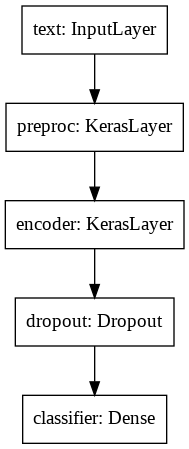

In [14]:
tf.keras.utils.plot_model(classifier_model)

## Model Training

In [15]:
#@title ### Loss function
#@markdown BinaryCrossEntropy from Logits.<br>
#@markdown Accuracy metric: Binary accuracy.
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

### Optimizer 
For fine-tunning, let's use the same optimizer the BERT was originally trained with: Adaptative Moments(ADAM). This optimizer minimizes the prediction loss and does regularization by weight decay(nout using moments), which is also known as AdamW.

For the learning rate `init_lr`, we use the same schedule as BERT during pretraining: linear decay of a nontional initial learning rate, prefixed with a linear warm-up phase of the 10% of training steps `num_warmup_steps`. In line with BERT, the initial learning rate is smaller for fine-tunning (best of 5e-5, 3e-5, 2e-5). 

In [16]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1 * num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(
    init_lr=init_lr,
    num_train_steps=num_train_steps,
    num_warmup_steps=num_warmup_steps,
    optimizer_type="adamw"
)

## Loading Model & Training

In [17]:
classifier_model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics
)

In [18]:
print(f"Training model with {tfhub_handle_encoder}")
history = classifier_model.fit(
    x=train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Epoch 1/5
625/625 [==============================] - 397s 611ms/step - loss: 0.4977 - binary_accuracy: 0.7123 - val_loss: 0.3270 - val_binary_accuracy: 0.8772
Epoch 2/5
625/625 [==============================] - 376s 602ms/step - loss: 0.2625 - binary_accuracy: 0.8883 - val_loss: 0.3468 - val_binary_accuracy: 0.8858
Epoch 3/5
625/625 [==============================] - 377s 603ms/step - loss: 0.1453 - binary_accuracy: 0.9472 - val_loss: 0.4997 - val_binary_accuracy: 0.8822
Epoch 4/5
625/625 [==============================] - 377s 603ms/step - loss: 0.0720 - binary_accuracy: 0.9775 - val_loss: 0.6324 - val_binary_accuracy: 0.8792
Epoch 5/5
625/625 [==============================] - 377s 603ms/step - loss: 0.0338 - binary_accuracy: 0.9912 - val_loss: 0.6537 - val_binary_accuracy: 0.8866


## Evaluate model

Let's see how the model performs. Two values will be returned. Loss (a number which represents the error, lower values are better), and accuracy.

In [19]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

782/782 [==============================] - 174s 223ms/step - loss: 0.6301 - binary_accuracy: 0.8862
Loss: 0.6300550103187561
Accuracy: 0.8861600160598755


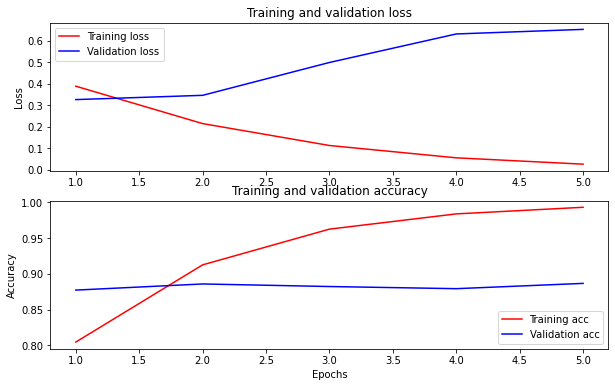

In [23]:
#@title ## Plot accuracy and loss
history_dict = history.history
# print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right');

## Export Model for Inference

In [33]:
dataset_name = "imdb"
dataset_name = dataset_name.replace("/", "_")
saved_model_path = f"./{dataset_name}_bert"
classifier_model.save(saved_model_path, include_optimizer=False)
print("Saved model:", saved_model_path)

Saved model: ./imdb_bert


Let's reload the model, so we can try it side by side with the model that is still in memory.

In [34]:
reloaded_model = tf.saved_model.load(saved_model_path)

Let's validate the `reloaded_model` accuracy.

In [35]:
def print_samples(inputs, results):
    result_for_printing = [
        f"input: {inputs[i]:<30}  score: {results[i][0]:.6f}"
        for i in range(len(inputs))
    ]
    print(*result_for_printing, sep="\n")
    print()


examples = [
    "this is such an amazing movie!",
    "The movie was great!",
    "The movie was meh.",
    "The movie was okish.",
    "The movie was terrible...",
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print("Results from the <saved> model:")
print_samples(examples, reloaded_results)

print("Results from the <original> model:")
print_samples(examples, original_results)

Results from the <saved> model:
input: this is such an amazing movie!  score: 0.997276
input: The movie was great!            score: 0.994143
input: The movie was meh.              score: 0.442030
input: The movie was okish.            score: 0.024655
input: The movie was terrible...       score: 0.000380

Results from the <original> model:
input: this is such an amazing movie!  score: 0.997276
input: The movie was great!            score: 0.994143
input: The movie was meh.              score: 0.442030
input: The movie was okish.            score: 0.024655
input: The movie was terrible...       score: 0.000380

